In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)
# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
#di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


import warnings
warnings.filterwarnings('ignore')

## Description
Two experiments on different days.
* **Experiment 1**: Adult worms were picked from a chucked ATR plate grown over the weekend.
* **Experiment 2**: L4 were picked form the same plate as in **Experiment 1** and let 24 on a fresh ATR plate.

Each experiment consist on three plates of strain A, and three plates of strain B. The recordings are done for 8 minutes. The light is turn on for ~15s every ~90s four times.

## Analysis
* I am using the *midbody speed* to identify backward and forward movement. I define a backward movement if the speed is less than -8.33pix/s (-100μm/s) and a forward movement if the speed is larger than 8.33pix/s (100μm/s).

* I am using a smoothing window of 5s on the plots *time vs fraction of worms*. I am using the raw data to calculate the mean values used in the boxplots. 

* I am doing a double-side t-test for p-values. Probably it is better to do a single-side.


## Results
* Strain B has the stronger response. There is a clear increase in the *fraction of worms going backwards* when the light is turn on (p-value 4.7x10<sup>-5</sup>), and a corresponding increase in the *fraction of worms going forward* when the light is turn off (1.74x10<sup>-4</sup>). 

* The effect in strain A is weaker: p-value 0.115 of an increase in the *fraction of worms going forward* when the light is on. The lower statistical significance was expected since it is harder to distingish between a spontaneous forward motion from an induced one. However, I think the result could have been better if I have waited a few minutes before starting the experiment to allow the worms to calm down.

* Interesting there does not seem to be an habituation response after the four pulses of blue-light.


In [2]:
%matplotlib inline
import glob
import os
import tables
import pandas as pd
import matplotlib.pylab as plt
from scipy.signal import medfilt
import numpy as np
import cv2
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

In [15]:
def add_is_reaction(feat_timeseries, th, is_reversal):
    feat_timeseries['is_reaction'] = 0
    for worm_index, tab in feat_timeseries.groupby('worm_index'):
        yy = tab['midbody_speed']
        #yy = tab['length']
        yy_med = medfilt(yy, 13)

        if is_reversal:
            feat_timeseries.loc[tab.index, 'is_reaction'] = (yy_med<-th)
        else:
            feat_timeseries.loc[tab.index, 'is_reaction'] = (yy_med>th)

    return feat_timeseries

def calc_n_worms(feat_timeseries):
    n_per_frame = feat_timeseries['timestamp'].value_counts()
    n_per_frame = n_per_frame.values
    if len(n_per_frame) > 0:
        n_worms_estimate = np.percentile(n_per_frame, 99)
    else:
        n_worms_estimate = 0
    return n_worms_estimate


def get_reaction_fraction(feat_timeseries, th, is_reversal, time_window_s, fps, frac_freq = None):
    if frac_freq is None:
        frac_freq = fps

    feat_timeseries = add_is_reaction(feat_timeseries, th, is_reversal)
    n_worms_estimate = calc_n_worms(feat_timeseries)
    
    first_frame = int(feat_timeseries['timestamp'].min())
    last_frame = int(feat_timeseries['timestamp'].max())
    
    frame_win = int((time_window_s)*fps)
    min_traj_size = 0.9*(frame_win+1)

    react_frac = np.full(last_frame+1, np.nan)
    half_win = frame_win//2
    for ini_win in range(first_frame, last_frame-half_win, frac_freq):
        last_win = ini_win + frame_win
        good = (feat_timeseries['timestamp']>=ini_win) & (feat_timeseries['timestamp']<=last_win)

        win_data = feat_timeseries[good]

        #print(ini_win, last_win, win_data.shape)
        good_ind = win_data['worm_index'].value_counts() >= min_traj_size
        valid_ind = good_ind[good_ind.values].index
        good = win_data['worm_index'].isin(valid_ind)
        win_data_v = win_data[good]

        if win_data_v.size == 0:
            continue

        has_event = win_data_v.groupby('worm_index').agg({'is_reaction':np.max})

        react_frac[ini_win + half_win] = np.sum(has_event['is_reaction'])/n_worms_estimate
    
    return react_frac



In [28]:
def get_reaction_data(mask_file, feat_file, th, is_reversal, time_window_s, fps):
    with tables.File(mask_file) as fid:
            mean_intensity = fid.get_node('/mean_intensity')[:]

    with pd.HDFStore(feat_file, 'r') as fid:
        feat_timeseries = fid['/features_timeseries']

    med = np.median(mean_intensity)
    mad = np.median(np.abs(mean_intensity-med))
    light_on = mean_intensity >  med + mad*6

    react_frac = get_reaction_fraction(feat_timeseries, th, is_reversal, time_window_s, fps)
    #react_frac = calc_reaction(feat_timeseries, th=th, is_reversal=is_reversal)
    
    
    return (light_on, react_frac)
        

def plot_reaction(mask_dir, result_dir, th, is_reversal, time_window_s, fps):
    feat_files = glob.glob(os.path.join(result_dir, '*_features.hdf5'))
    feat_files = sorted(feat_files, key=lambda x:x.split('_')[-2])
    feat_files = [x for x in feat_files if any(os.path.basename(x).startswith(good) for good in ['A', 'B'])]
    
    mask_files = [x.replace('_features.hdf5', '.hdf5') for x in feat_files]
    if mask_dir != result_dir:
        mask_files = [x.replace(result_dir, mask_dir) for x in mask_files]
    
    reaction_data = {}
    n_rows = round(len(mask_files)/2)
    plt.figure(figsize=(20,20))
    for ii, (mask_file, feat_file) in enumerate(zip(mask_files, feat_files)):
        
        light_on, react_frac = get_reaction_data(mask_file, 
                                                 feat_file, 
                                                 th, is_reversal, time_window_s, fps)
        
        base_name = os.path.basename(mask_file).replace('.hdf5', '')
        reaction_data[base_name] = (light_on, react_frac)
        
        plt.subplot(n_rows, 2, ii+1)
        
        if is_reversal:
            lab_t = 'fraction worms going backwards'
        else:
            lab_t = 'fraction worms going forward'
        
        
#         box_pts =  1#25*5
#         box = np.ones(box_pts)/box_pts
#         react_frac_s = np.convolve(react_frac, box, mode='same')
        
        xx = np.arange(light_on.size)/fps
        
        good = ~np.isnan(react_frac)
        d1, = plt.plot(xx[good], react_frac[good], label=lab_t)
        d2, = plt.plot(xx, light_on, label = 'light on')
        plt.legend(handles=[d1, d2], loc=2, prop={'size':12})
        plt.ylim((0, 1.2))
        
        plt.title(base_name, fontsize=14)
        plt.xlabel('time (s)', fontsize=14)
        
        
    return reaction_data


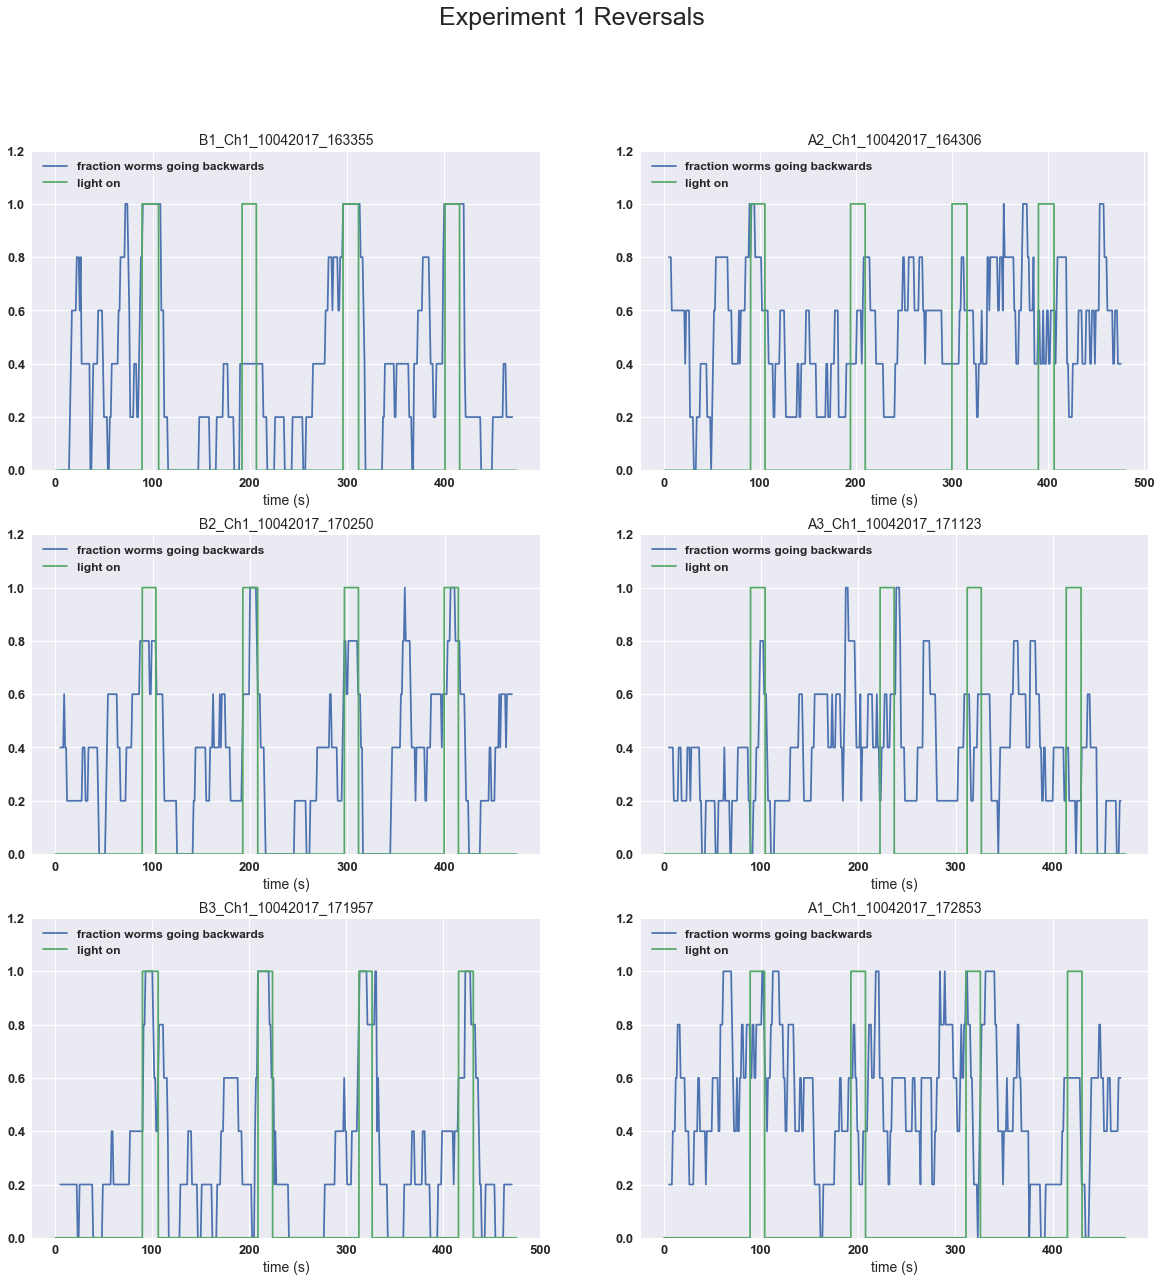

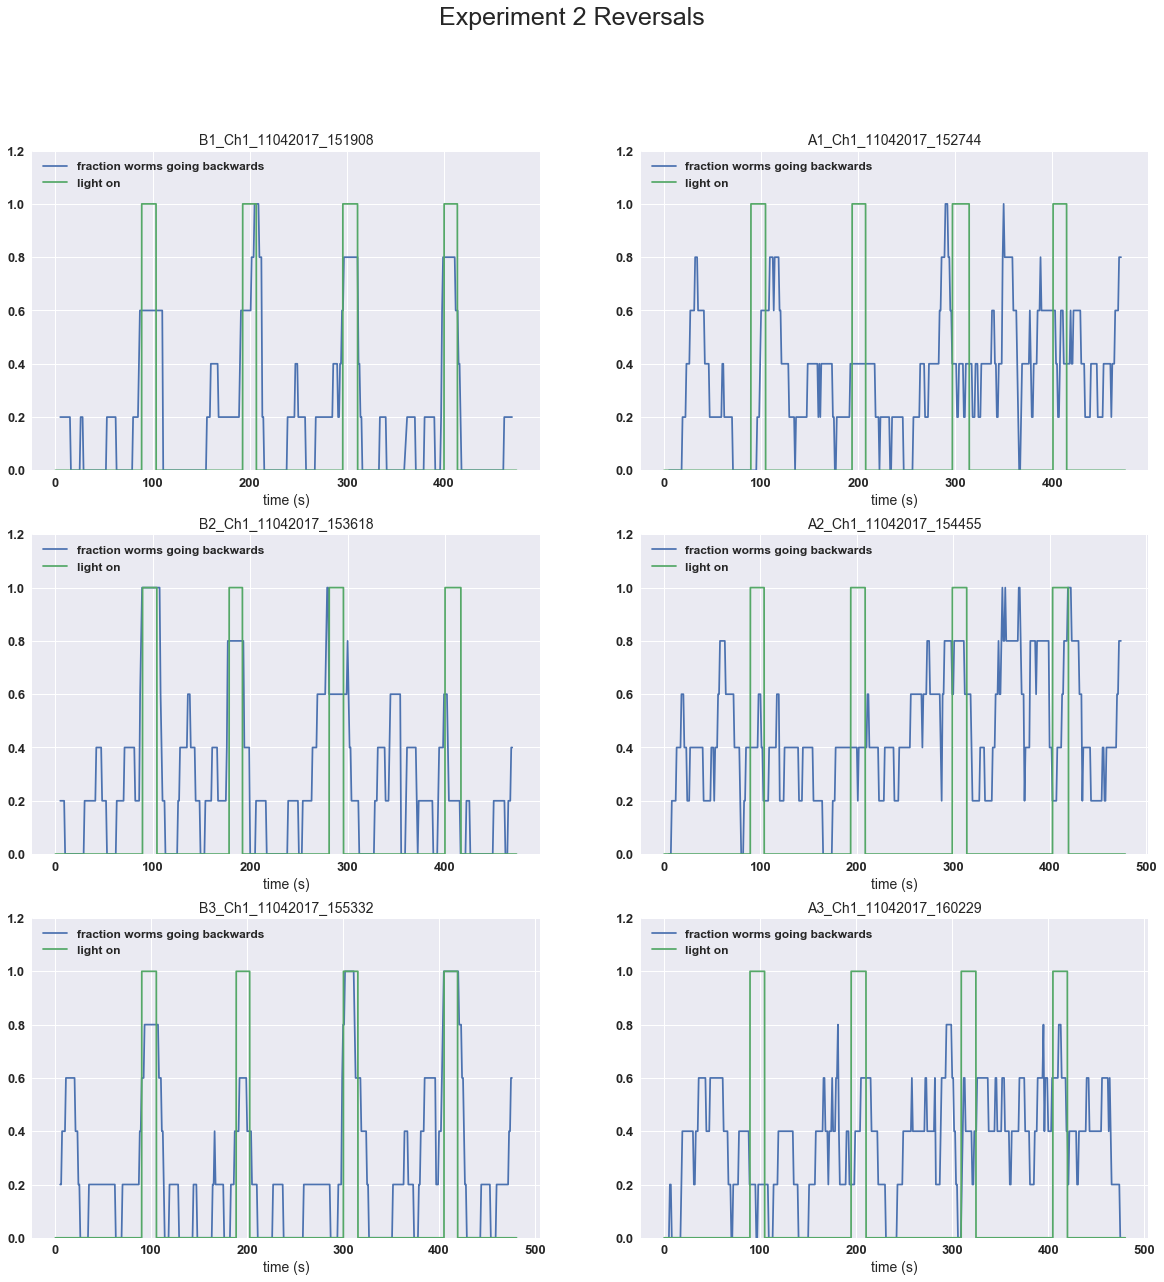

In [48]:
THRESH = 8.3
time_window_s = 10
fps =25

#mask_dir = '/Users/ajaver/OneDrive - Imperial College London/tests/ATR_100417'
#result_dir = mask_dir
reversals_data = {}

mask_dir = '/Volumes/behavgenom_archive$/Avelino/screening/David_Miller/MaskedVideos/ATR_100417'
result_dir = mask_dir.replace('MaskedVideos', 'Results')
reversals_data['exp1'] = plot_reaction(mask_dir, result_dir, th=THRESH, 
                                       is_reversal=True, time_window_s=time_window_s, fps=fps)
plt.suptitle('Experiment 1 Reversals', fontsize=25)

mask_dir = '/Volumes/behavgenom_archive$/Avelino/screening/David_Miller/MaskedVideos/ATR_110417_fromL4'
result_dir = mask_dir.replace('MaskedVideos', 'Results')
reversals_data['exp2'] = plot_reaction(mask_dir, result_dir, th=THRESH, 
                                       is_reversal=True, time_window_s=time_window_s, fps=fps)
plt.suptitle('Experiment 2 Reversals', fontsize=25)

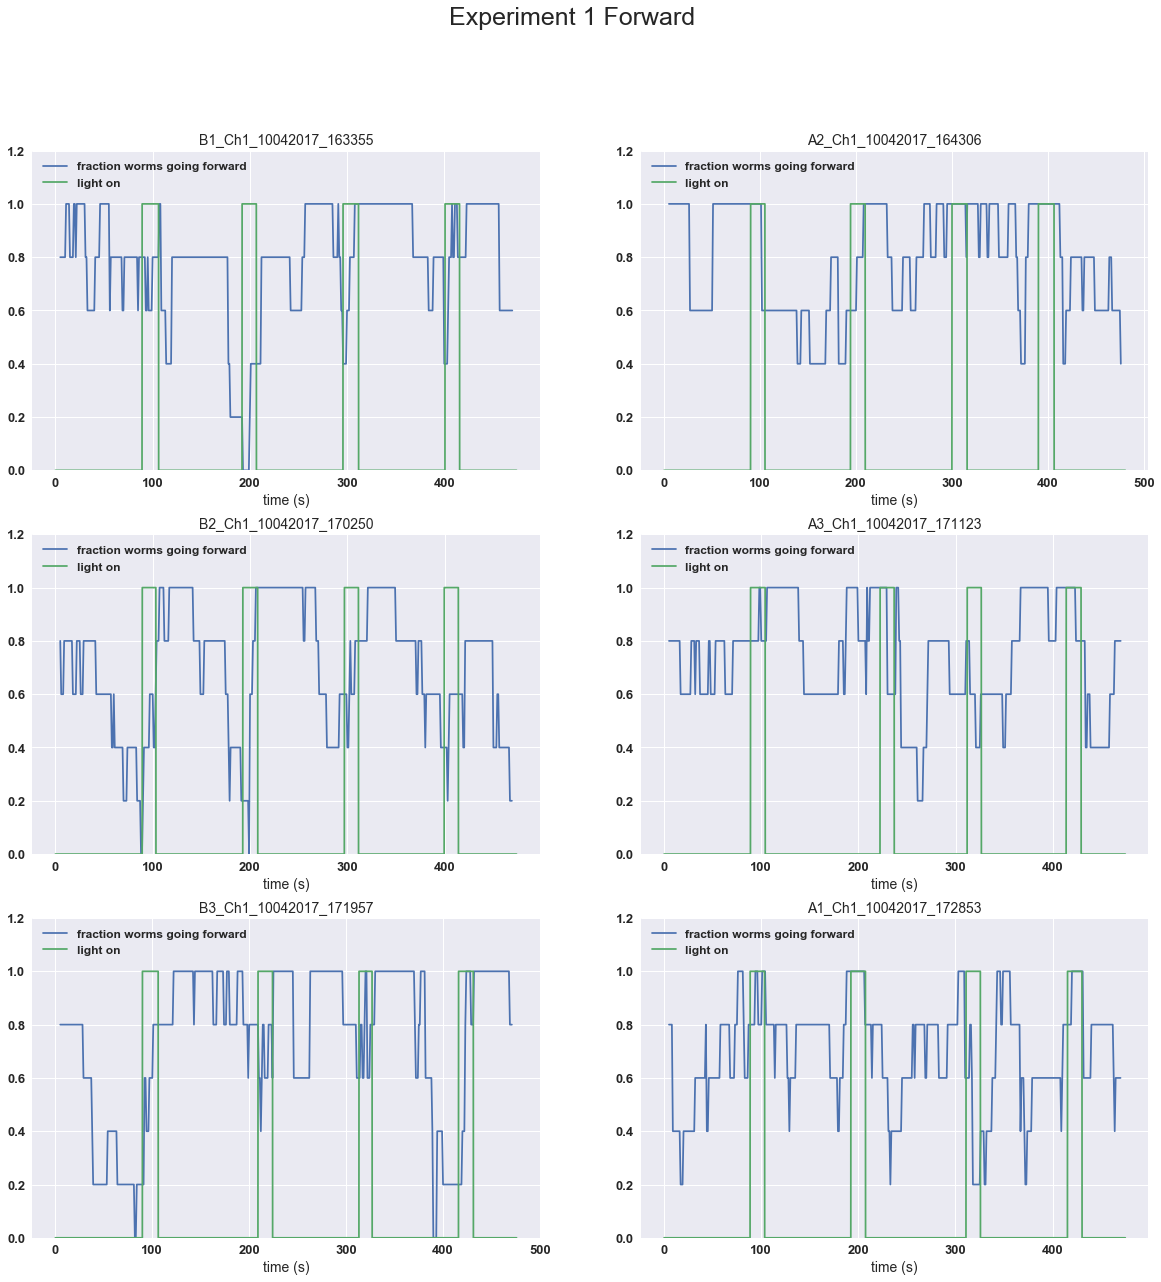

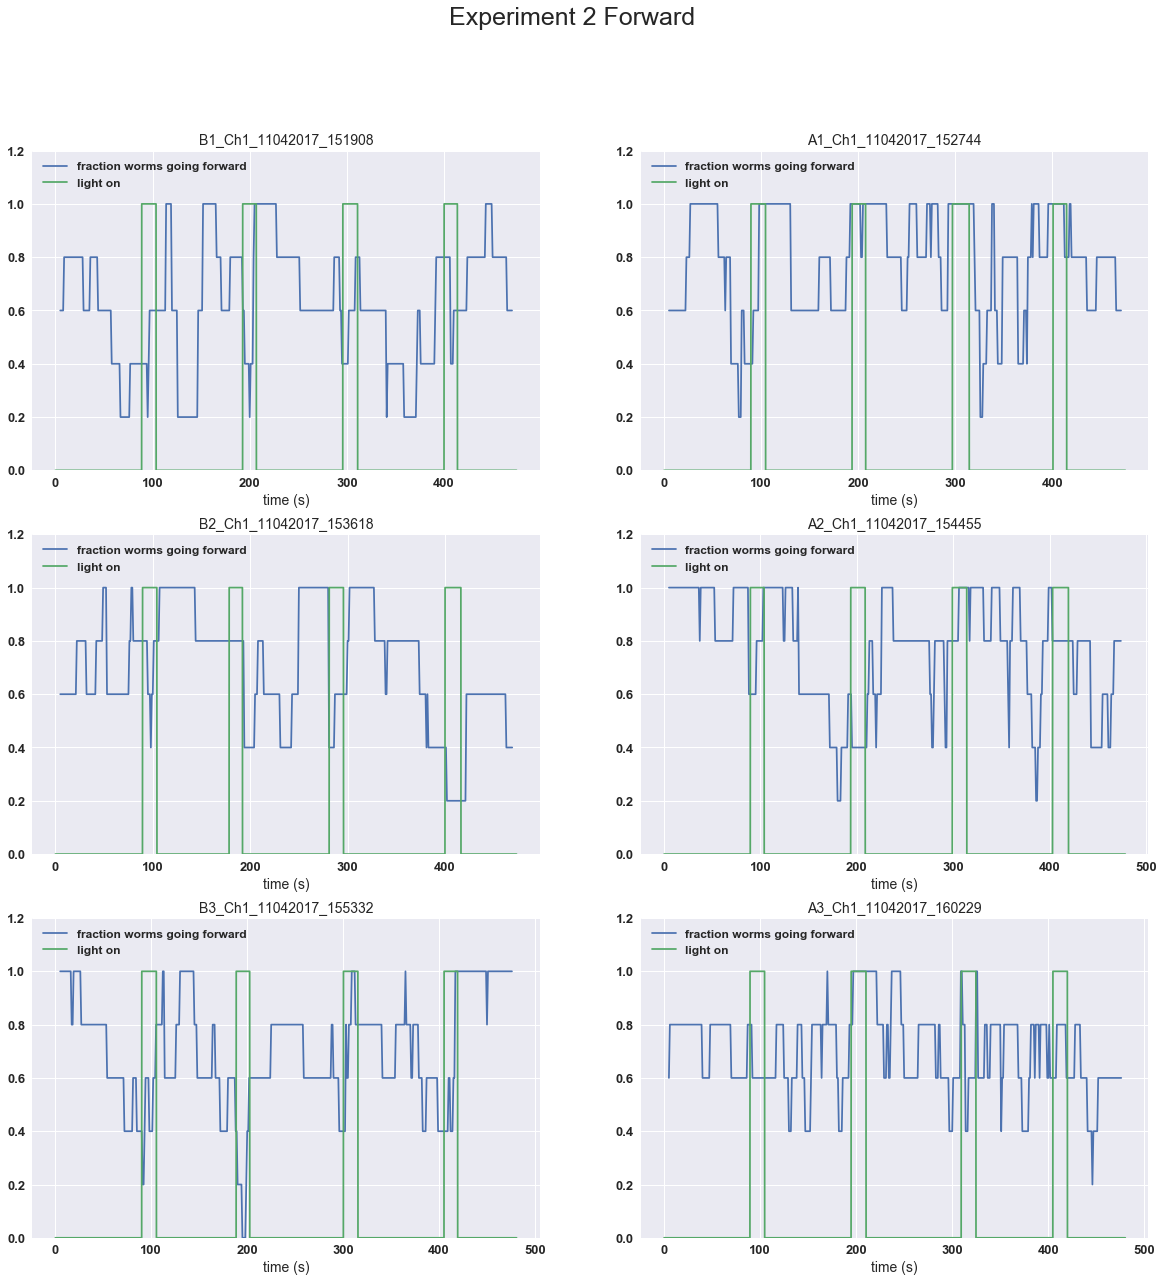

In [49]:
#mask_dir = '/Users/ajaver/OneDrive - Imperial College London/tests/ATR_100417'
#result_dir = mask_dir
forwards_data = {}
mask_dir = '/Volumes/behavgenom_archive$/Avelino/screening/David_Miller/MaskedVideos/ATR_100417'
result_dir = mask_dir.replace('MaskedVideos', 'Results')
forwards_data['exp1'] = plot_reaction(mask_dir, result_dir, th=THRESH, 
                                      is_reversal=False,time_window_s=time_window_s, fps=fps)
plt.suptitle('Experiment 1 Forward', fontsize=25)

mask_dir = '/Volumes/behavgenom_archive$/Avelino/screening/David_Miller/MaskedVideos/ATR_110417_fromL4'
result_dir = mask_dir.replace('MaskedVideos', 'Results')
forwards_data['exp2'] = plot_reaction(mask_dir, result_dir, th=THRESH, 
                                      is_reversal=False,time_window_s=time_window_s, fps=fps)
plt.suptitle('Experiment 2 Forward', fontsize=25)

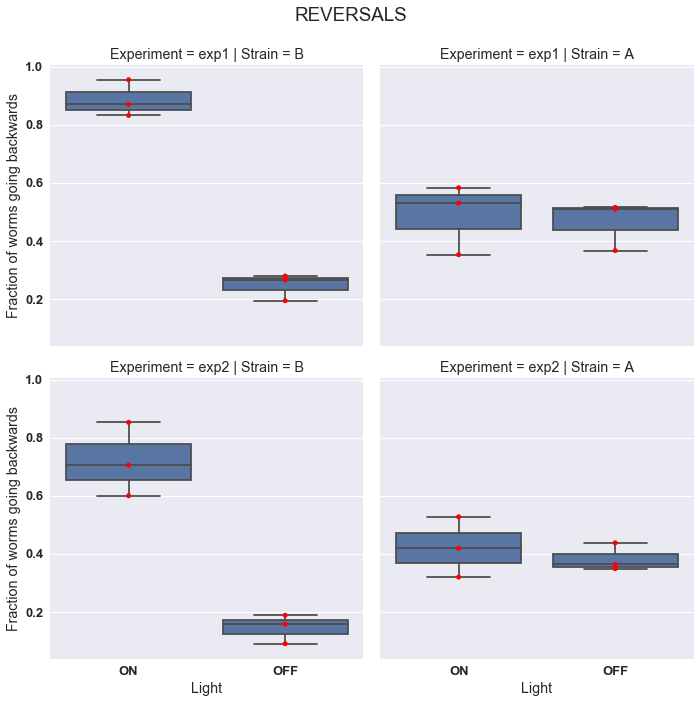

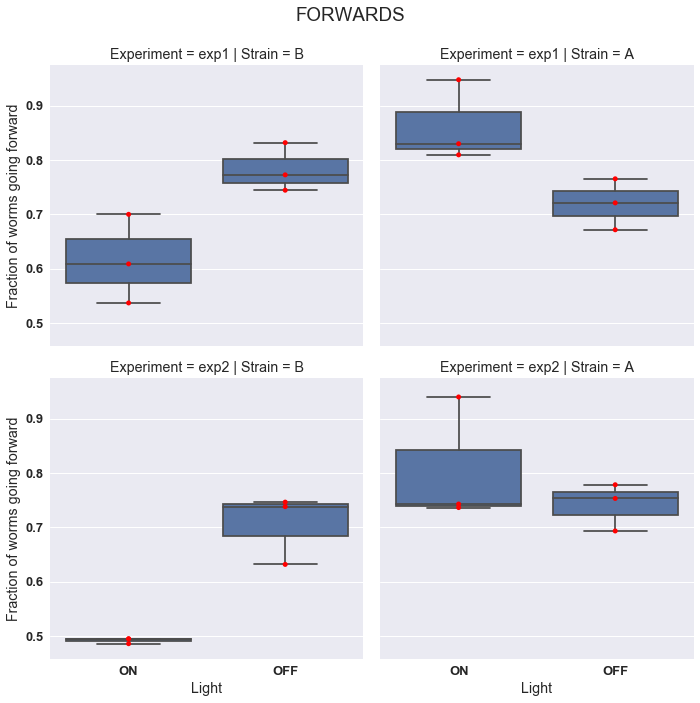

In [52]:
box_pts = time_window_s*fps+1
def box_plot_data(reaction_data, is_reversal):
    if is_reversal:
        reaction_str = 'Fraction of worms going backwards'
        title_str = 'REVERSALS'
    else:
        reaction_str = 'Fraction of worms going forward'
        title_str = 'FORWARDS'
    
    results = []
    for exp, dat in reaction_data.items():
        for key, (light_on, reaction_frac) in dat.items():
            box = np.ones(box_pts)/box_pts
            light_on_v = np.convolve(light_on, box, mode='same')
            good_off = light_on_v==0
            good_on = light_on_v>.99
            results.append((exp, key[0], 'ON', np.nanmean(reaction_frac[good_on])))
            results.append((exp, key[0], 'OFF', np.nanmean(reaction_frac[good_off])))

    results = pd.DataFrame(results, columns=['Experiment', 'Strain', 'Light', reaction_str])

    sns.set(font_scale=1.3)
    g = sns.FacetGrid(results, col="Strain", row='Experiment', size=5, aspect=1)
    g = g.map(sns.boxplot, "Light", reaction_str)
    g = g.map(sns.stripplot, "Light", reaction_str, color="r")
    
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(title_str)
    
    return results

results_reversal = box_plot_data(reversals_data, is_reversal=True)
results_forward = box_plot_data(forwards_data, is_reversal=False)



In [51]:
from scipy.stats import ttest_ind
def get_p_values(results, is_reverse=True):
    p_values = []
    for strain, s_data in results.groupby('Strain'):
        if is_reverse:
            fraction_reaction = s_data['Fraction of worms going backwards']
        else:
            fraction_reaction = s_data['Fraction of worms going forward']
        x = fraction_reaction[s_data['Light']=='OFF'].values
        y = fraction_reaction[s_data['Light']=='ON'].values

        _, p = ttest_ind(x,y, equal_var=False)

        p_values.append((strain, p))

    p_values = pd.DataFrame(p_values, columns=['strain', 'p_value'])
    
    return p_values



print('BACKWARD')
p_values = get_p_values(results_reversal, is_reverse=True)
print(p_values)

print('FORWARD')
p_values = get_p_values(results_forward, is_reverse=False)
print(p_values)

BACKWARD
  strain   p_value
0      A  0.567176
1      B  0.000009
FORWARD
  strain   p_value
0      A  0.040561
1      B  0.001670


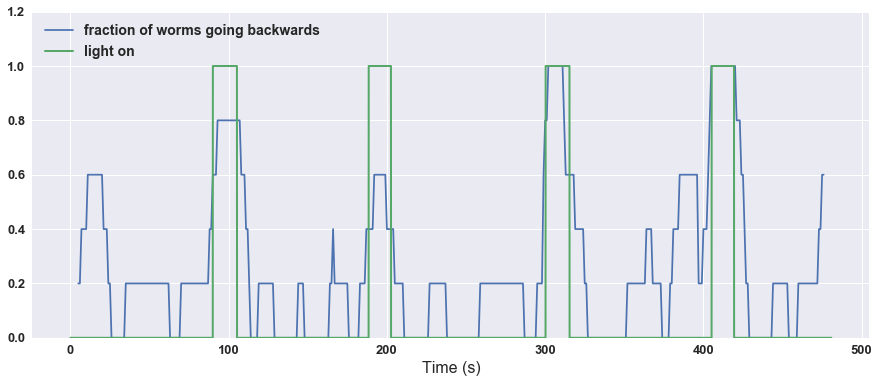

In [53]:
mask_file = '/Volumes/behavgenom_archive$/Avelino/screening/David_Miller/MaskedVideos/ATR_110417_fromL4/B3_Ch1_11042017_155332.hdf5'
feat_file = mask_file.replace('MaskedVideos', 'Results').replace('.hdf5', '_features.hdf5')

light_on, react_frac = get_reaction_data(mask_file, feat_file, th=THRESH, is_reversal=True, time_window_s=time_window_s, fps=fps)

xx = np.arange(light_on.size)/25

graph = plt.figure(figsize=(15, 6))
good = ~np.isnan(react_frac)
d1, = plt.plot(xx[good], react_frac[good], label='fraction of worms going backwards within a window of {}s'.format())
d2, = plt.plot(xx, light_on, label = 'light on', linewidth=2)
plt.legend(handles=[d1, d2], loc=2, prop={'size':14})
plt.ylim((0, 1.2))
plt.xlabel('Time (s)', fontsize=16)


with PdfPages('strainB_time_fraction_backwards.pdf') as pp:
    pp.savefig(graph)

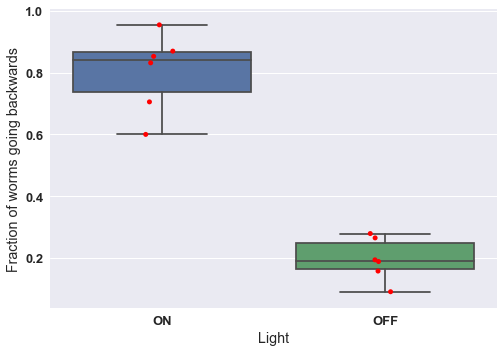

In [54]:
strain_b_data = results_reversal[results_reversal['Strain']=='B']

graph = plt.figure()
sns.boxplot(x='Light', 
            y='Fraction of worms going backwards', 
            data=strain_b_data)
sns.stripplot(x='Light', 
              y='Fraction of worms going backwards', 
              color='r', 
              jitter=True,
              data=strain_b_data)

with PdfPages('boxplot_fraction_backwards.pdf') as pp:
    pp.savefig(graph)